In [1]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

In [3]:
df = pd.read_csv('fulton.csv')
df.head()

,Mon,Tue,Wed,Thu,Date,Stormy,p,q
0,1,0,0,0,1,1,1.569217,8.994421
1,0,1,0,0,2,1,2.000000,7.707063
2,0,0,1,0,3,0,2.072321,8.350194
3,0,0,0,1,4,1,2.247139,8.656955
4,0,0,0,0,5,1,2.664327,7.844241


### 1)

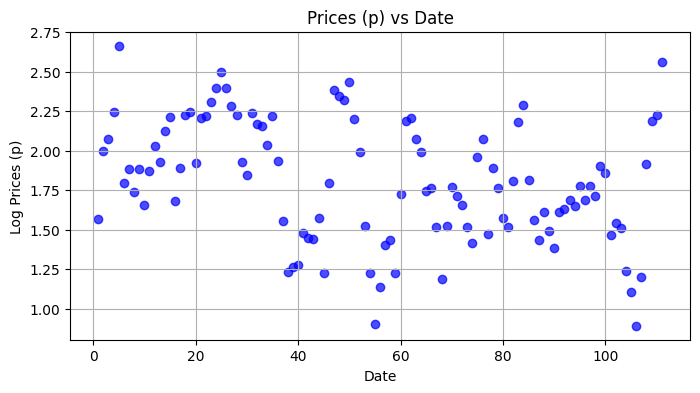

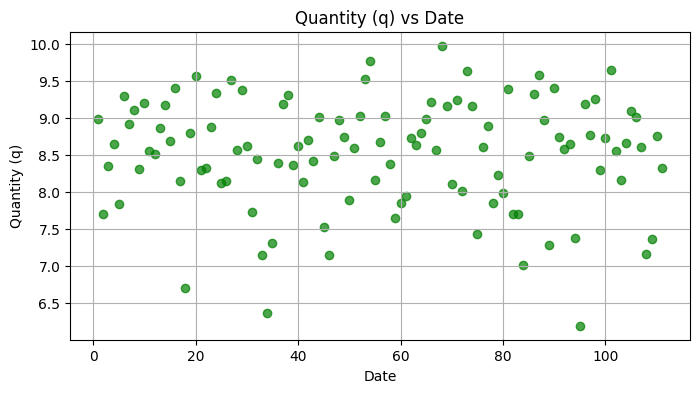

In [4]:
# (a) Scatterplots

# Prices vs Date
plt.figure(figsize=(8, 4))
plt.scatter(df['Date'], df['p'], alpha=0.7, color='blue')
plt.title('Prices (p) vs Date')
plt.xlabel('Date')
plt.ylabel('Log Prices (p)')
plt.grid(True)
plt.show()

# Quantity vs Date
plt.figure(figsize=(8, 4))
plt.scatter(df['Date'], df['q'], alpha=0.7, color='green')
plt.title('Quantity (q) vs Date')
plt.xlabel('Date')
plt.ylabel('Quantity (q)')
plt.grid(True)
plt.show()

The prices exhibit moderate variation with some peaks and troughs, indicating that the pricing strategy might involve some degree of flexibility based on external factors like demand or market conditions.

Quantity sold appears to fluctuate, but not as much as prices. This suggests that the quantity sold may be somewhat stable, potentially due to factors like consistent customer demand or a lack of extreme price changes.

The lack of a clear upward or downward trend in both graphs may suggest that quantity sold and price are not strictly correlated over time. The prices seem to vary, but the quantity remains relatively stable, which could imply that price changes might not be influencing the quantity sold significantly. This could be a result of factors other than price affecting demand, such as market saturation, availability, or seasonality.

In [5]:
# (b) Average price (p) and quantity (q) of fish sold on each weekday (Mon-Thu)

weekday_cols = ['Mon', 'Tue', 'Wed', 'Thu']
average_values = {}

for day in weekday_cols:
    avg_price = df.loc[df[day] == 1, 'p'].mean()
    avg_quantity = df.loc[df[day] == 1, 'q'].mean()
    average_values[day] = {'Average Price (p)': avg_price, 'Average Quantity (q)': avg_quantity}

# Find the day with the highest price
highest_price_day = max(average_values, key=lambda x: average_values[x]['Average Price (p)'])
highest_price = average_values[highest_price_day]['Average Price (p)']

# Print the results
print("Average price and quantity of fish sold on each weekday:")
for day, values in average_values.items():
    print(f"{day}: Average Price (p) = {values['Average Price (p)']:.2f}, Average Quantity (q) = {values['Average Quantity (q)']:.2f}")

print(f"\nFish are sold for the highest price on {highest_price_day} with an average price of {highest_price:.2f}.")


Average price and quantity of fish sold on each weekday:
Mon: Average Price (p) = 1.75, Average Quantity (q) = 8.76
Tue: Average Price (p) = 1.79, Average Quantity (q) = 8.21
Wed: Average Price (p) = 1.80, Average Quantity (q) = 8.16
Thu: Average Price (p) = 1.87, Average Quantity (q) = 8.76

Fish are sold for the highest price on Thu with an average price of 1.87.


Looks like demand is highest on Thursday, hence the high price even though quantity is same as on Mon when the price is lowest as well. This could be because businesses (e.g., restaurants or consumers) stock up for Friday and Saturday.

Another reason could be reduced supply of higher quality of fish explaining price increases on Thursday. Stormy weather earlier in the week may have disrupted supply, indirectly impacting prices later in the week.

## 2)

In [6]:
# Linear Regression Model

regression_df = df.drop(columns=['Stormy', 'Date'])
formula = 'q ~ ' + ' + '.join(regression_df.drop(columns=['q']).columns)

model = smf.ols(formula, data=regression_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      q   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     5.940
Date:                Fri, 22 Nov 2024   Prob (F-statistic):           7.08e-05
Time:                        00:27:41   Log-Likelihood:                -110.00
No. Observations:                 111   AIC:                             232.0
Df Residuals:                     105   BIC:                             248.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.7320      0.336     28.936      0.0

In [7]:
# (a) Regression equation

coefficients = model.params
regression_equation = (
    f"q = {coefficients['Intercept']:.2f} + {coefficients['Mon']:.2f} * Mon "
    f"+ {coefficients['Tue']:.2f} * Tue + {coefficients['Wed']:.2f} * Wed "
    f"+ {coefficients['Thu']:.2f} * Thu + {coefficients['p']:.2f} * p"
)
print("Regression Equation:")
print(regression_equation)


Regression Equation:
q = 9.73 + 0.01 * Mon + -0.52 * Tue + -0.56 * Wed + 0.08 * Thu + -0.56 * p


(b) Performance of model

R-squared value indicates that the independent variables explain approximately 22% of the variance in the dependent variable (quantity). The model's predictive power is relatively weak.

Significant variables (p-value < 0.05) :- Tue, Wed, p

Insignificant variables with high p-value :- Mon, Thu

(c) Change (price) v/s Change(quantity)

Coefficient of p is -0.5625. This means that for each unit increase in p, the quantity sold decreases by approximately 0.5625, holding all other variables constant. This intuitively makes sense that as price increases, quantity sold decreases.

Yes, we can use the coefficient of price (p) to estimate the effect of price on quantity, but with caution. Since p is a transformed version of the raw price (logarithm of price + 2), the coefficient describes the effect of changes in the transformed price, not the raw price. To interpret the direct effect of price, the transformation would need to be reversed.

## 3)

(a) Why 'Stormy' is a good predictor

- The instrument must be correlated with our variable price, p. Lagged weather conditions, such as stormy weather, can be a good instrument because weather can affect the supply of fish and hence the prices on a given day. Stormy weather can influence the availability of fish, causing price fluctuations.  (Relevance)
- The instrument (stormy) must not directly affect the dependent variable, except through its effect on the regressor (price), i.e, lagged weather should not directly affect the quantity sold on the day being observed, but only indirectly by influencing the price.   (Endogeneity)

(b) Can 'stormy' directly correlate to q?

Yes, lagged stormy weather could directly correlate with the quantity of fish sold if stormy weather affects demand or other factors unrelated to price.

For example:

Demand Effect: If stormy weather disrupts normal consumer behavior (e.g., fewer customers shopping or staying home due to bad weather), it could directly reduce the quantity of fish sold on that day, independent of price.

Logistics Effect: Stormy weather might also disrupt the delivery or availability of fish, which could affect the quantity sold, regardless of price fluctuations.

In [8]:
# (c) IV regression

iv_regression = IV2SLS.from_formula('q ~ 1 + [p ~ Stormy] + Mon + Tue + Wed + Thu', df)
iv_regression_result = iv_regression.fit()
print(iv_regression_result.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                      q   R-squared:                      0.1391
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0981
No. Observations:                 111   F-statistic:                    24.946
Date:                Fri, Nov 22 2024   P-value (F-stat)                0.0001
Time:                        00:27:43   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      10.745     0.7860     13.671     0.0000      9.2043      12.285
Mon           -0.0254     0.2154    -0.1179     0.90

(d) Change in coefficient of p

In the IV regression model, the coefficient for p changed from -0.5625 in the OLS regression to -1.1194. This change is expected because instrumental variables estimation corrects for endogeneity by addressing potential correlation between the price and the error term, which could have biased the OLS results. The IV method uses "Stormy" as an instrument for price, isolating the effect of price on q from other confounding factors. This correction often leads to a larger absolute coefficient for price, as the IV approach typically provides a more accurate estimate of the causal effect of price on quantity.

In [9]:
# (e) Updated regression equation

intercept_iv = iv_regression_result.params['Intercept']
mon_iv = iv_regression_result.params['Mon']
tue_iv = iv_regression_result.params['Tue']
wed_iv = iv_regression_result.params['Wed']
thu_iv = iv_regression_result.params['Thu']
p_iv = iv_regression_result.params['p']

regression_equation_iv = f"q = {intercept_iv:.2f} + {mon_iv:.2f} * Mon + {tue_iv:.2f} * Tue + {wed_iv:.2f} * Wed + {thu_iv:.2f} * Thu + {p_iv:.2f} * p"
print(regression_equation_iv)

q = 10.74 + -0.03 * Mon + -0.53 * Tue + -0.57 * Wed + 0.11 * Thu + -1.12 * p


## 4)

In [10]:
# (a)

Mon = 1
Tue = Wed = Thu = 0
p = 0.1

quantity_mon = intercept_iv + mon_iv * Mon + tue_iv * Tue + wed_iv * Wed + thu_iv * Thu + p_iv * p
revenue_mon = quantity_mon * p
print(f"Revenue on Monday: {revenue_mon:.2f}")

Revenue on Monday: 1.06


In [11]:
# (b)

prices = np.arange(0, 6.01, 0.01)

revenues = []
for price in prices:
    quantity = intercept_iv + mon_iv * Mon + tue_iv * Tue + wed_iv * Wed + thu_iv * Thu + p_iv * price
    revenue = quantity * price
    revenues.append(revenue)

revenues = np.array(revenues)

# see top few results
top_results = list(zip(prices[:10], revenues[:10]))
for price, revenue in top_results:
    print(f"Price: {price:.2f}, Revenue: {revenue:.2f}")

Price: 0.00, Revenue: 0.00
Price: 0.01, Revenue: 0.11
Price: 0.02, Revenue: 0.21
Price: 0.03, Revenue: 0.32
Price: 0.04, Revenue: 0.43
Price: 0.05, Revenue: 0.53
Price: 0.06, Revenue: 0.64
Price: 0.07, Revenue: 0.74
Price: 0.08, Revenue: 0.85
Price: 0.09, Revenue: 0.96


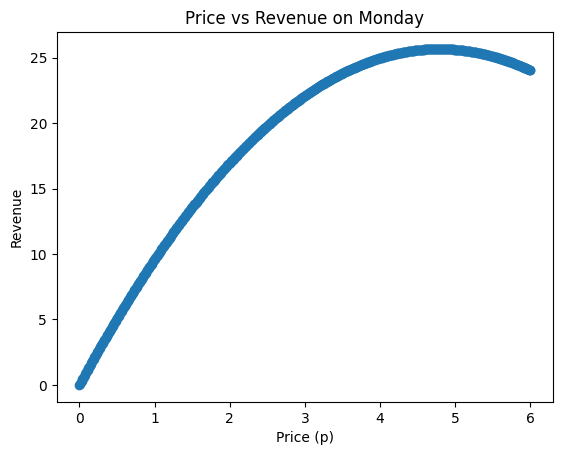

In [12]:
# (c)

plt.scatter(prices, revenues)
plt.title("Price vs Revenue on Monday")
plt.xlabel("Price (p)")
plt.ylabel("Revenue")
plt.show()

From the plot, the optimal price for maximum revenue on Monday is around 4.5, where the revenue peaks before starting to decline. Exact price is calculated below.

In [13]:
from scipy.optimize import minimize

def revenue_function(price, intercept_iv, mon_iv, tue_iv, wed_iv, thu_iv, p_iv, Mon=1, Tue=0, Wed=0, Thu=0):
    quantity = intercept_iv + mon_iv * Mon + tue_iv * Tue + wed_iv * Wed + thu_iv * Thu + p_iv * price
    revenue = quantity * price
    return -revenue

result = minimize(revenue_function, x0=1.0, args=(intercept_iv, mon_iv, tue_iv, wed_iv, thu_iv, p_iv))

optimal_price = result.x[0]

print(f"The optimal price to maximize revenue on Monday is: {optimal_price:.2f}")

The optimal price to maximize revenue on Monday is: 4.79


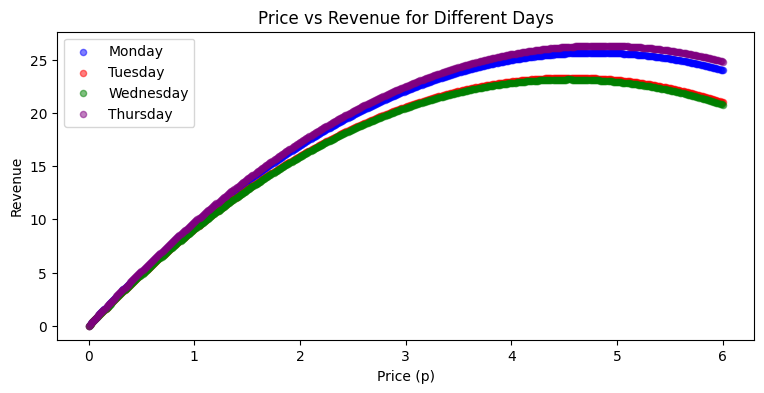

In [16]:
# (d)

# Function to calculate revenue for a given day
def calculate_revenue_for_day(day, p_value):
    days = {'Mon': [1, 0, 0, 0], 'Tue': [0, 1, 0, 0], 'Wed': [0, 0, 1, 0], 'Thu': [0, 0, 0, 1]}

    # Set day-specific values
    Mon, Tue, Wed, Thu = days[day]

    # Calculate quantity and revenue for the given price value
    quantity = intercept_iv + mon_iv * Mon + tue_iv * Tue + wed_iv * Wed + thu_iv * Thu + p_iv * p_value
    return quantity * p_value

# Calculate revenues for each day (Tue, Wed, Thu)
revenues_tue = [calculate_revenue_for_day('Tue', price) for price in prices]
revenues_wed = [calculate_revenue_for_day('Wed', price) for price in prices]
revenues_thu = [calculate_revenue_for_day('Thu', price) for price in prices]

# Plotting revenues for all days using scatter plots with adjusted size and transparency
plt.figure(figsize=(9, 4))

# Scatter plot for Monday, Tuesday, Wednesday, and Thursday with smaller points and increased transparency
plt.scatter(prices, revenues, label='Monday', color='blue', alpha=0.5, s=20)
plt.scatter(prices, revenues_tue, label='Tuesday', color='red', alpha=0.5, s=20)
plt.scatter(prices, revenues_wed, label='Wednesday', color='green', alpha=0.5, s=20)
plt.scatter(prices, revenues_thu, label='Thursday', color='purple', alpha=0.5, s=20)

plt.title("Price vs Revenue for Different Days")
plt.xlabel("Price (p)")
plt.ylabel("Revenue")
plt.legend()
plt.show()


In [17]:
# optimal prices for each day


# Define the revenue function
def revenue_function(price, intercept_iv, mon_iv, tue_iv, wed_iv, thu_iv, p_iv, Mon, Tue, Wed, Thu):
    quantity = intercept_iv + mon_iv * Mon + tue_iv * Tue + wed_iv * Wed + thu_iv * Thu + p_iv * price
    revenue = quantity * price
    return -revenue  # Return negative revenue for minimization

# Function to calculate optimal price for a given day
def get_optimal_price_for_day(intercept_iv, mon_iv, tue_iv, wed_iv, thu_iv, p_iv, day):
    if day == 'Mon':
        Mon, Tue, Wed, Thu = 1, 0, 0, 0
    elif day == 'Tue':
        Mon, Tue, Wed, Thu = 0, 1, 0, 0
    elif day == 'Wed':
        Mon, Tue, Wed, Thu = 0, 0, 1, 0
    elif day == 'Thu':
        Mon, Tue, Wed, Thu = 0, 0, 0, 1
    else:
        raise ValueError("Invalid day. Use 'Mon', 'Tue', 'Wed', or 'Thu'.")

    # Find the price that maximizes revenue by minimizing the negative revenue function
    result = minimize(revenue_function, x0=1.0, args=(intercept_iv, mon_iv, tue_iv, wed_iv, thu_iv, p_iv, Mon, Tue, Wed, Thu))

    # Get the optimal price
    optimal_price = result.x[0]
    return optimal_price

# Get optimal price for each day of the week
optimal_price_mon = get_optimal_price_for_day(intercept_iv, mon_iv, tue_iv, wed_iv, thu_iv, p_iv, 'Mon')
optimal_price_tue = get_optimal_price_for_day(intercept_iv, mon_iv, tue_iv, wed_iv, thu_iv, p_iv, 'Tue')
optimal_price_wed = get_optimal_price_for_day(intercept_iv, mon_iv, tue_iv, wed_iv, thu_iv, p_iv, 'Wed')
optimal_price_thu = get_optimal_price_for_day(intercept_iv, mon_iv, tue_iv, wed_iv, thu_iv, p_iv, 'Thu')

# Print the optimal prices
print(f"Optimal price for Monday: {optimal_price_mon:.2f}")
print(f"Optimal price for Tuesday: {optimal_price_tue:.2f}")
print(f"Optimal price for Wednesday: {optimal_price_wed:.2f}")
print(f"Optimal price for Thursday: {optimal_price_thu:.2f}")

Optimal price for Monday: 4.79
Optimal price for Tuesday: 4.56
Optimal price for Wednesday: 4.55
Optimal price for Thursday: 4.85
